<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/MultiphaseflowMeasurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Multiphase flow measurements
#@markdown This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
import pandas as pd
%matplotlib inline

# Multiphase flow measurement
A multiphase flow meter is a device used to measure the individual phase flow rates of constituent phases in a given flow (for example in oil and gas industry) where oil, water and gas mixtures are initially co-mingled together during the oil production processes.

# Litterature

Wikipedia

https://en.wikipedia.org/wiki/Multiphase_flow_meter


HANDBOOK OF MULTIPHASE FLOW METERING:

https://nfogm.no/wp-content/uploads/2014/02/MPFM_Handbook_Revision2_2005_ISBN-82-91341-89-3.pdf

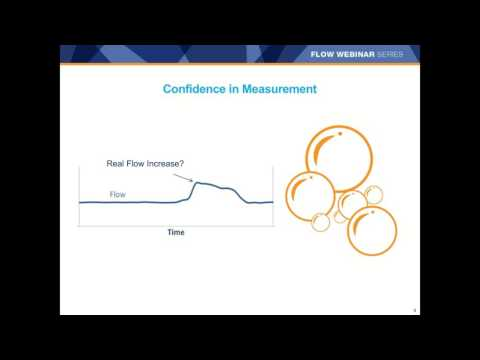

In [3]:
#@title Webinar: Advances in Multiphase Metering for Onshore Measurement in Oil & Gas
#@markdown This video gives an intriduction to Oil & Gas facilities Design
from IPython.display import YouTubeVideo
YouTubeVideo('mcxrjJwidl0', width=600, height=400)

# Generation of fluid characterization and generationg PVT properites for multi phase meters

In the following section it will be demonstrated how to generate PVT data for a multi phase flow meter. The steps in generation of PVT tables will be:


1. Collection of fluid composition and PVT data from a PVT report
2. Set up fluid composition based on compositional analysis in PVT report, calulate and compare to measured PVT properties from PVT report
3. Selection of parameters to fit, and fit model to PVT data
4. Gerenation of properties for multi phase flow meter

# 1. Collection of fluid composition and PVT data from PVTbreport. Evaluation of data.

We start by optaining a fluid composition and PVT data from a PVT report. The fluid compositon can typically be reported based on a bottom hole sample or from a test separator. The gas and oil from the sample is analysed, and matehamtical recombined into a well stream composition.

In this example we will use a fluid characterization based on a C10+ analysis. A detailed composition is reported up to C6, and the C6, C7, C8 and C9 is defned as oil fraction components with properties calculated based on molar mass nnd density. C10+ is added with molar mass and density of the 10+ fraction.





In [4]:
gascondensate = {'ComponentName':   ['nitrogen','CO2', 'methane', 'ethane', 'propane','i-butane','n-butane','i-pentane','n-pentane',"C6", "C7", "C8", "C9", "C10"], 
        'MolarComposition[-]':  [0.972, 0.632, 95.111, 2.553, 0.104, 0.121, 0.021, 0.066, 0.02,0.058, 0.107, 0.073, 0.044, 0.118], 
        'MolarMass[kg/mol]': [None, None, None, None, None, None, None, None, None, 0.08618, 0.096, 0.107, 0.121, 0.202],
        'RelativeDensity[-]': [None, None, None, None, None, None, None, None, None, 664.0e-3, 738.0e-3, 765.0e-3, 781.0e-3, 813.30e-3]} 

compositionDataFrame = pd.DataFrame(gascondensate) 
print(compositionDataFrame.head(20).to_string())


   ComponentName  MolarComposition[-]  MolarMass[kg/mol]  RelativeDensity[-]
0       nitrogen                0.972                NaN                 NaN
1            CO2                0.632                NaN                 NaN
2        methane               95.111                NaN                 NaN
3         ethane                2.553                NaN                 NaN
4        propane                0.104                NaN                 NaN
5       i-butane                0.121                NaN                 NaN
6       n-butane                0.021                NaN                 NaN
7      i-pentane                0.066                NaN                 NaN
8      n-pentane                0.020                NaN                 NaN
9             C6                0.058            0.08618              0.6640
10            C7                0.107            0.09600              0.7380
11            C8                0.073            0.10700              0.7650

## Data from PVT report
Typical data from a PVT report is reported in the following code. In the following example the fluid composition was reported based on test separarator data, and a constand mass expansion test was done (CME). Reservoir pressure and temperature.

    pressure  relative volume   Zgas  Density      Bg  gasexpansionfactor  gasviscosity
0      555.3           0.7410  1.247   0.2671  0.0027               365.6        0.0325
1      552.0           0.7431  1.244   0.2663  0.0027               364.6        0.0324
2      518.5           0.7660  1.204   0.2583  0.0028               353.7        0.0313
3      484.0           0.7917  1.162   0.2499  0.0029               342.2        0.0301
4      449.5           0.8210  1.119   0.2410  0.0030               330.0        0.0288
5      415.3           0.8551  1.077   0.2314  0.0032               316.8        0.0276
6      408.1           0.8631  1.068   0.2293  0.0032               313.9        0.0273
7      401.3           0.8710  1.060   0.2272  0.0032               311.0        0.0270
8      394.3           0.8795  1.051   0.2250  0.0032               308.0        0.0268
9      387.3           0.8883  1.043   0.2227  0.0033               305.0        0.0265
10     380.7           0.8972  1

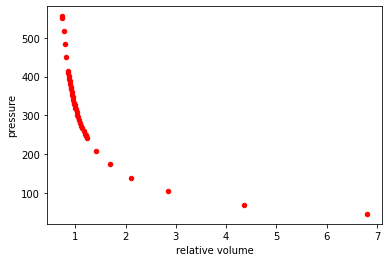

In [5]:
reservoirTemperature = 80.6 #Celius
reservoirPressure = 320.8 #bara

testSeparatorTemperature = 20.6 # Celcius
testSeparatorPressure = 86.8 # bara
GORseparartorConditions = 58959.0 # Sm3 gas//m3 condesate

GORstandardConditions = 55000.0 # Sm3 gas/Sm3 condesate


# Define a dictionary with PVT data
PVTdata = {'pressure':  [555.3,552,518.5,484,449.5,415.3,408.1,401.3,394.3,387.3,380.7,373.8,366.7,360,352.9,346.2,339.3,332.3,329.9,325.6,320,315.1,308.4,301.3,294.5,287.6,280.6,273.8,266.9,259.9,253.1,249.5,246.1,242.7,208.2,173.6,139,104.5,70,46.1], 
        'relative volume': [0.741,0.7431,0.766,0.7917,0.821,0.8551,0.8631,0.871,0.8795,0.8883,0.8972,0.9066,0.9169,0.9272,0.9385,0.9498,0.9621,0.9751,0.9797,0.9883,1,1.0105,1.0258,1.0428,1.0602,1.0787,1.0989,1.1197,1.1423,1.1668,1.1924,1.2064,1.2202,1.2346,1.4135,1.6806,2.1038,2.8422,4.3612,6.796],
        'Zgas': [1.247,1.244,1.204,1.162,1.119,1.077,1.068,1.06,1.051,1.043,1.035,1.027,1.019,1.012,1.004,0.997,0.99,0.982,0.98,0.976,0.97,0.965,0.959,0.952,0.946,0.941,0.935,0.929,0.924,0.919,0.915,0.912,0.91,0.908,0.892,0.884,0.887,0.9,0.926,0.95],
        'Density': [0.2671,0.2663,0.2583,0.2499,0.241,0.2314,0.2293,0.2272,0.225,0.2227,0.2206,0.2183,0.2158,0.2134,0.2108,0.2083,0.2057,0.2029,0.202,0.2002,0.1979,0.1958,0.1929,0.1898,0.1866,0.1834,0.1801,0.1767,0.1732,0.1696,0.1659,0.164,0.1622,0.1603,0.14,0.1177,0.0941,0.0696,0.0454,0.0291],
        'Bg': [0.0027,0.0027,0.0028,0.0029,0.003,0.0032,0.0032,0.0032,0.0032,0.0033,0.0033,0.0033,0.0034,0.0034,0.0035,0.0035,0.0036,0.0036,0.0036,0.0036,0.0037,0.0037,0.0038,0.0038,0.0039,0.004,0.0041,0.0041,0.0042,0.0043,0.0044,0.0045,0.0045,0.0046,0.0052,0.0062,0.0078,0.0105,0.0161,0.0251],
        'gasexpansionfactor': [365.6,364.6,353.7,342.2,330,316.8,313.9,311,308,305,302,298.8,295.5,292.2,288.7,285.2,281.6,277.8,276.5,274.1,270.9,268.1,264.1,259.8,255.5,251.1,246.5,241.9,237.2,232.2,227.2,224.6,222,219.4,191.7,161.2,128.8,95.3,62.1,39.9],
        'gasviscosity': [0.0325,0.0324,0.0313,0.0301,0.0288,0.0276,0.0273,0.027,0.0268,0.0265,0.0262,0.0259,0.0257,0.0254,0.0251,0.0248,0.0245,0.0243,0.0242,0.024,0.0237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        } 

# Convert the PVT data dictionary into DataFrame 
CMEdataFrame = pd.DataFrame(PVTdata) 
CMEpressures = CMEdataFrame['pressure'].tolist()
CMEtemperature = [80.6+273.15]*len(CMEpressures)

#print and plot the PVT data
print(CMEdataFrame.head(50).to_string())

print("plotting experimental PVT data.....")
CMEdataFrame.plot(kind='scatter',x='relative volume',y='pressure',color='red')
plt.show()



# 2. Set up fluid based on fluid composition and properties from PVT report, calculate and compare to measured PVT properties from PVT report

A fluid in neqsim is set up in the following script. We the flash the fluid to calculate the GOR at test separator and standard conditions. Further we will plot the phase envelope of the fluid.

## Setting up the fluid based on the PVT report
In the follwing script we create a neqsim fluid based on composition and data for oil components (molar mass and density) from the PVT report. We will then calcuate the phase envelope based on this fluid characterization.

phase envelope for characterized fluid


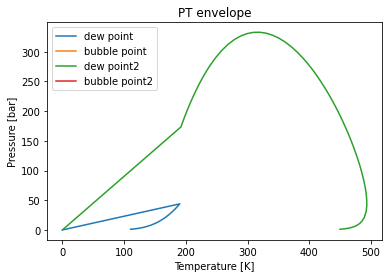

JavaObject id=o9

In [6]:
# Running PVTsimulation with default fluid
characterizedFluid = fluid_df(compositionDataFrame, lastIsPlusFraction=True)
print('phase envelope for characterized fluid')
phaseenvelope(characterizedFluid, True)

## Compare neqsim calculations to data from PVT report
In the folllowing script we run neqsim simulations to compare how well the PVT data from the PVT report can be represented by the default fluid characterization. NeqSim will by default use SRK-EoS with Peneloux volume correction.

We start by comparing to measured GOR at separator and standard conditions.

In [7]:
characterizedFluid.setTemperature(15.0, "C")
characterizedFluid.setPressure(1.0, "atm")
TPflash(characterizedFluid)
#printFLuidCharacterisation(characterizedFluid) #print componentnames, TC, PC, acs, molar mass, density, 
printFrame(characterizedFluid)
GORcalcstd = characterizedFluid.getPhase("gas").getNumberOfMolesInPhase()*8.314*288.15/101325  / (characterizedFluid.getPhase("oil").getVolume("m3"))
print("GOR at standard conditions ", GORcalcstd, " Sm3 gas/m3 oil. ", " Deviation from PVT report: ", (GORcalcstd-GORstandardConditions)/GORstandardConditions*100, " %")

characterizedFluid.setTemperature(testSeparatorTemperature, "C")
characterizedFluid.setPressure(testSeparatorPressure, "bara")
TPflash(characterizedFluid)
GORcalc = characterizedFluid.getPhase("gas").getNumberOfMolesInPhase()*8.314*288.15/101325  / (characterizedFluid.getPhase("oil").getVolume("m3"))
print("GOR at test separator conditions: ", GORcalc, " Sm3 gas/m3 oil" , " Deviation from PVT report: ", (GORcalc-GORseparartorConditions)/GORseparartorConditions*100, " %")

#Calculating saturation pressure
#characterizedFluid.setTemperature(reservoirTemperature, "C")
#calcSatPres = saturationpressure(characterizedFluid)
#print("Saturation pressure : ", calcSatPres, " [bara]" , " Deviation from PVT report: ", (calcSatPres-reservoirPressure), " bar")

                          total          gas          oil                     
           nitrogen     9.72E-3   9.73274E-3   1.44183E-5      [mole fraction]
                CO2     6.32E-3   6.32815E-3   1.09143E-4      [mole fraction]
            methane   9.5111E-1   9.52352E-1   5.34311E-3      [mole fraction]
             ethane    2.553E-2   2.55623E-2   9.62774E-4      [mole fraction]
            propane     1.04E-3   1.04116E-3   1.55289E-4      [mole fraction]
           i-butane     1.21E-3   1.21097E-3   4.69601E-4      [mole fraction]
           n-butane      2.1E-4   2.10114E-4   1.23476E-4      [mole fraction]
          i-pentane      6.6E-4   6.59488E-4   1.04996E-3      [mole fraction]
          n-pentane        2E-4   1.99689E-4   4.37212E-4      [mole fraction]
              C6_PC      5.8E-4   5.69453E-4    8.6143E-3      [mole fraction]
              C7_PC     1.07E-3   1.01947E-3   3.95601E-2      [mole fraction]
              C8_PC      7.3E-4   6.46731E-4   6.415

## Comparing to PVT data
In this case CME (constant mass expansion) experiments have been performed, and we will compare to these data.

    pressure  sim relative volume   Zgassim  densitysim     Bgsim  gasviscositysim
0      555.3             0.789109  1.287465  315.279733  0.002319         0.000040
1      552.0             0.790854  1.282644  314.573007  0.002324         0.000039
2      518.5             0.809834  1.233718  307.085995  0.002381         0.000038
3      484.0             0.832180  1.183406  298.715718  0.002448         0.000036
4      449.5             0.858093  1.133274  289.563543  0.002525         0.000035
5      415.3             0.888299  1.083908  279.578131  0.002615         0.000033
6      408.1             0.895355  1.073576  277.344120  0.002637         0.000033
7      401.3             0.902272  1.063844  275.188340  0.002657         0.000032
8      394.3             0.909667  1.053853  272.920741  0.002679         0.000032
9      387.3             0.917355  1.043893  270.602056  0.002702         0.000032
10     380.7             0.924892  1.034534  268.367187  0.002725         0.000031
11  

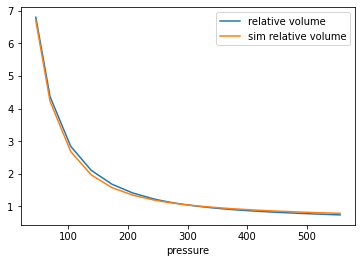

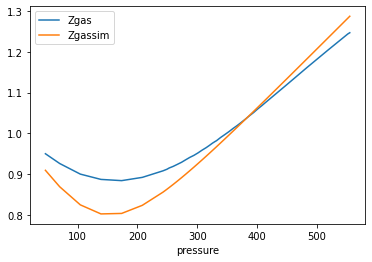

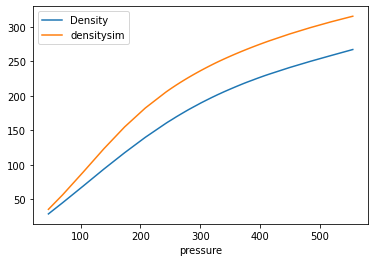

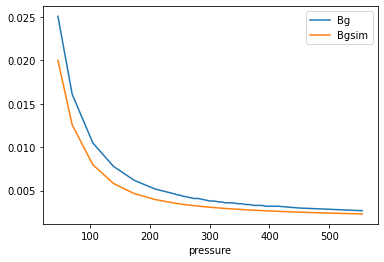

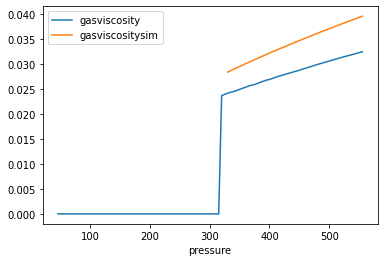

Deviation analysis...
Average deviation relative volume:  0.7012709270039393  %   Max devation  6.492379066350436  %


In [8]:
simrelativevolume = []
simliquidrelativevolume = []
Zgas =  []
Bgsim=[]
densitysim =  []
Yfactor = []
isothermalcompressibility = []
gasviscositysim = []
saturationPressure = None
CME(characterizedFluid,CMEpressures,CMEtemperature,saturationPressure,simrelativevolume, simliquidrelativevolume,Zgas,Yfactor,isothermalcompressibility,densitysim,Bgsim, gasviscositysim)
CMEsimdataFrame = pd.DataFrame(numpy.transpose([CMEpressures, simrelativevolume,Zgas, densitysim, Bgsim, gasviscositysim]), columns=["pressure", "sim relative volume","Zgassim", "densitysim", "Bgsim", "gasviscositysim"])
print(CMEsimdataFrame.head(50).to_string())
print("saturation pressure simulated ", saturationPressure)
pd.concat([CMEdataFrame['pressure'], CMEdataFrame['relative volume'],CMEsimdataFrame['sim relative volume']],axis=1).plot(x='pressure')
pd.concat([CMEdataFrame['pressure'], CMEdataFrame['Zgas'],CMEsimdataFrame['Zgassim']],axis=1).plot(x='pressure')
pd.concat([CMEdataFrame['pressure'], CMEdataFrame['Density']*1e3,CMEsimdataFrame['densitysim']],axis=1).plot(x='pressure')
pd.concat([CMEdataFrame['pressure'], CMEdataFrame['Bg'],CMEsimdataFrame['Bgsim']],axis=1).plot(x='pressure')
pd.concat([CMEdataFrame['pressure'], CMEdataFrame['gasviscosity'],CMEsimdataFrame['gasviscositysim']*1e3],axis=1).plot(x='pressure',kind="line")

matplotlib.pyplot.show()

devanalysisframe = pd.concat([CMEdataFrame['pressure'], (CMEsimdataFrame['sim relative volume']-CMEdataFrame['relative volume'])/CMEdataFrame['relative volume']*100.0],axis=1)
print("Deviation analysis...")
print("Average deviation relative volume: ", devanalysisframe[0].mean(), " %", "  Max devation ", devanalysisframe[0].max() , " %")





# 3. Selection of parameters to fit, and fit model to PVT data
To be done...

# 4. Gerenation of properties for multi phase flow meter

A typical multi phase flow meter will need calclation of various thermodynamic and physical properties. Such properties have to be updated as the field is produced. The input to the property calculations are a characterized fluid composition from PVT studies.

The following script demonstrates calculation of PVT properties for a multi phase flow meter using a characterized fluid composition.

In [10]:
#Creating property tables
pressures = [150.0, 170.0, 180.0, 200.0, 270.0]
temperatures = [30.0, 40.0, 50.0, 60.0, 80.0]

numP = len(pressures)
numT = len(temperatures)

gasViscosity = numpy.zeros((numP, numT))
oilViscosity = numpy.zeros((numP, numT))
gasDensity = numpy.zeros((numP, numT))
oilDensity = numpy.zeros((numP, numT))
GORcalc  = numpy.zeros((numP, numT))
GORactual = numpy.zeros((numP, numT))
surfaceTension = numpy.zeros((numP, numT))
gasViscosity[:] = np.NaN
oilViscosity[:] = np.NaN
gasDensity[:] = np.NaN
oilDensity[:] = np.NaN
GORcalc[:] = np.NaN
GORactual[:] = np.NaN
surfaceTension[:] = np.NaN

for i in range(len(temperatures)):
  for j in range(len(pressures)):
    characterizedFluid.setPressure(pressures[j])
    characterizedFluid.setTemperature(temperatures[i]+273.15)
    TPflash(characterizedFluid)
    characterizedFluid.initProperties()
    if(characterizedFluid.hasPhaseType("gas")):
      gasViscosity[j][i]=characterizedFluid.getPhase("gas").getViscosity("cP")
      gasDensity[j][i]=characterizedFluid.getPhase("gas").getDensity("kg/m3")
    if(characterizedFluid.hasPhaseType("oil")):
      oilViscosity[j][i]=characterizedFluid.getPhase("oil").getViscosity("cP")
      oilDensity[j][i]=characterizedFluid.getPhase("oil").getDensity("kg/m3")
    if(characterizedFluid.hasPhaseType("gas") and characterizedFluid.hasPhaseType("oil")):
      GORcalc[j][i] = characterizedFluid.getPhase("gas").getNumberOfMolesInPhase()*8.314*288.15/101325  / (characterizedFluid.getPhase("oil").getVolume("m3"))
      GORactual[j][i] =   (characterizedFluid.getPhase("gas").getVolume("m3"))/ (characterizedFluid.getPhase("oil").getVolume("m3"))
      surfaceTension[j][i]  = characterizedFluid.getInterfacialTension('gas', 'oil')

gasDensityDataFrame = pd.DataFrame(gasDensity,index=pressures, columns=temperatures)
oilDensityDataFrame = pd.DataFrame(oilDensity,index=pressures, columns=temperatures)
gasviscosityDataFrame = pd.DataFrame(gasViscosity,index=pressures, columns=temperatures)
oilviscosityDataFrame = pd.DataFrame(oilViscosity,index=pressures, columns=temperatures)
GORcalcFrame = pd.DataFrame(GORcalc,index=pressures, columns=temperatures)
GORactualFrame = pd.DataFrame(GORactual,index=pressures, columns=temperatures)
surfaceTensionFrame= pd.DataFrame(surfaceTension,index=pressures, columns=temperatures)

print("gas density [kg/m3]")
print(gasDensityDataFrame.tail())
print("oil density [kg/m3]")
print(oilDensityDataFrame.head())
print("gas viscosity [(mPa.s)]")
print(gasviscosityDataFrame.tail())
print("oil viscosity [(mPa.s)]")
print(oilviscosityDataFrame.head())
#print("GOR (Sm3/m3)")
#print(GORcalcFrame.head())
print("GOR actual (m3/m3)")
print(GORactualFrame.head())
print("Surface Tension (N/m)")
print(surfaceTensionFrame.head())

gas density [kg/m3]
             30.0        40.0        50.0        60.0        80.0
150.0  121.935641  114.949909  108.900278  103.599170   94.714901
170.0  138.398441  130.434465  123.507438  117.424292  107.220476
180.0  146.285848  137.905926  130.592058  124.155080  113.338494
200.0  161.275437  152.217294  144.244094  137.184549  125.254449
270.0  205.184428  195.082902  185.890170  177.528059  162.970587
oil density [kg/m3]
             30.0        40.0        50.0        60.0        80.0
150.0  697.048104  701.635842  706.055301  710.246227  717.895164
170.0  695.717818  700.132784  704.465394  708.654965  716.585445
180.0  695.871286  700.127027  704.365027  708.520544  716.556526
200.0  697.816871  701.638276  705.604803  709.634870  717.792276
270.0  721.061445  722.381140  724.353822  726.748208  731.873476
gas viscosity [(mPa.s)]
           30.0      40.0      50.0      60.0      80.0
150.0  0.016654  0.016559  0.016528  0.016547  0.016686
170.0  0.017760  0.017555  0.017